In [1]:
import biolqm
import stablemotifs
from colomoto_jupyter import tabulate
import pandas as pd

This notebook has been executed using the docker image `colomoto/colomoto-docker:2020-07-01`

In [2]:
!lscpu|grep name

Model name:          Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz


Lets first import the T-LGL leukemia model used in Zanudo et al. 2015 (DOI: 10.1371/journal.pcbi.1004571) and display its Boolean rules

In [3]:
model = biolqm.load("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")

Downloading http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml

In [4]:
target = {"CellCycleArrest": 1,"EMT":1,"Invasion":1,"Migration":1,"Metastasis":1,"Apoptosis":0}

The model contains a large number of cycles, so the algorithm in StableMotifs needs to include a threshold in the maximal cycle length it uses to construct the stable motifs, which are then used to obtain the reprogramming interventions.

Note: There are more efficient algorithms for finding stable motifs that are not yet implemented (e.g. the one in PyBoolNet: https://github.com/hklarner/PyBoolNet). Using these more efficient algorithms would not require such a threshold and would make the program much faster. Future releases will include these more efficient algorithms.

In [5]:
fixed = {"ECMicroenv": 0, "DNAdamage": 0}
%time stm00 = stablemotifs.load(model, fixed, mcl=10, msm=10000, quiet=True) #Max cycle size for SM seems to be 10

CPU times: user 21.2 ms, sys: 15.9 ms, total: 37 ms
Wall time: 2min 30s


In [6]:
fixed = {"ECMicroenv": 1, "DNAdamage": 0}
%time stm10 = stablemotifs.load(model,fixed, mcl=5, msm=10000, quiet=True) #Max cycle size for SM seems to be 5

CPU times: user 13.8 ms, sys: 10.6 ms, total: 24.5 ms
Wall time: 1min 11s


In [7]:
fixed = {"ECMicroenv": 0, "DNAdamage": 1}
%time stm01 = stablemotifs.load(model, fixed, mcl=7, msm=10000, quiet=True) #Max cycle size for SM seems to be 7

CPU times: user 125 ms, sys: 274 ms, total: 398 ms
Wall time: 44min 22s


In [8]:
fixed = {"ECMicroenv": 1, "DNAdamage": 1}
%time stm11 = stablemotifs.load(model, fixed, mcl=5, msm=10000, quiet=True) #Max cycle size for SM seems to be 5

CPU times: user 24.4 ms, sys: 35.8 ms, total: 60.2 ms
Wall time: 5min 22s


In [9]:
r00 = stm00.reprogramming_to_attractor(target)
r00

[]

In [10]:
r10 = stm10.reprogramming_to_attractor(target)
r10

[FromCondition('input', TemporaryPerturbation(SNAI2=1)),
 FromCondition('input', TemporaryPerturbation(p53=0))]

In [11]:
r10.as_table()

,SNAI2,p53
0,,0
1,1,


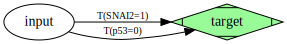

In [12]:
r10.as_graph()

In [13]:
r01 = stm01.reprogramming_to_attractor(target)
r01

[]

In [14]:
r11 = stm11.reprogramming_to_attractor(target)
r11

[FromCondition('input', TemporaryPerturbation(NICD=1, SNAI2=1)),
 FromCondition('input', TemporaryPerturbation(SNAI2=1, p63=0)),
 FromCondition('input', TemporaryPerturbation(NICD=1, ZEB1=1, p53=0)),
 FromCondition('input', TemporaryPerturbation(NICD=1, miR200=0, p53=0)),
 FromCondition('input', TemporaryPerturbation(NICD=1, p53=0, p73=0)),
 FromCondition('input', TemporaryPerturbation(ZEB1=1, p53=0, p63=0)),
 FromCondition('input', TemporaryPerturbation(p53=0, p63=0, p73=0))]

In [15]:
r11.as_table()

,NICD,SNAI2,ZEB1,miR200,p53,p63,p73
0,,,,,0,0,0
1,,,1,,0,0,
2,,1,,,,0,
3,1,,,,0,,0
4,1,,,0,0,,
5,1,,1,,0,,
6,1,1,,,,,


As a reprogramming example, consider the case of the environmental signal ECMicroenv=1 DNAdamage=1. Under this threshold, we can identify the two attractors. Specifically, we identify attractors HS and EMT2 (using the terminology of Cohen et al.).

In [16]:
tabulate(stm00.attractors)

,CellCycleArrest,ECMicroenv,Metastasis,Apoptosis,DNAdamage,Migration,Invasion,TGFbeta,CTNNB1,miR203,miR200,TWIST1,SNAI2,SNAI1,miR34,NICD,ZEB1,ZEB2,DKK1,SMAD,AKT1,AKT2,CDH1,CDH2,ERK,VIM,p21,EMT,p63,p53,p73,GF
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,1,1,1,0,1,0,0,0,1


These attractors have the associated stable motfis and reprogramming interventions

In [17]:
stm00.stable_motifs

[{'CDH2': 1,
  'CTNNB1': 0,
  'SNAI1': 1,
  'TWIST1': 1,
  'miR203': 0,
  'miR34': 0,
  'p53': 0},
 {'AKT2': 0,
  'CDH1': 1,
  'CTNNB1': 0,
  'SNAI1': 0,
  'SNAI2': 0,
  'TWIST1': 0,
  'ZEB1': 0,
  'ZEB2': 0}]

In [18]:
stm00.control_sets

{0: [{'SNAI1': 1}, {'TWIST1': 1, 'miR34': 0}, {'TWIST1': 1, 'p53': 0}],
 1: [{'CDH1': 1, 'SNAI1': 0},
  {'CDH1': 1, 'TWIST1': 0},
  {'CTNNB1': 0, 'SNAI1': 0},
  {'CTNNB1': 0, 'TWIST1': 0},
  {'SNAI2': 0, 'TWIST1': 0, 'ZEB1': 0}]}

We can now identify reprogramming interventions for each of the attractors with EMT=0, which is only one of them in this case (named HS in the work of Cohen et al.).

In [19]:
stm00.reprogramming_to_attractor(EMT=0)

[FromCondition('input', TemporaryPerturbation(CDH1=1, SNAI1=0)),
 FromCondition('input', TemporaryPerturbation(CDH1=1, TWIST1=0)),
 FromCondition('input', TemporaryPerturbation(CTNNB1=0, SNAI1=0)),
 FromCondition('input', TemporaryPerturbation(CTNNB1=0, TWIST1=0)),
 FromCondition('input', TemporaryPerturbation(SNAI2=0, TWIST1=0, ZEB1=0))]

As another reprogramming example, consider the case of the environmental signal ECMicroenv=1 DNAdamage=1. Under this threshold, we can identify two of the three attractors. Specifically, we identify attractors Apo3 and M1.

In [20]:
tabulate(stm11.attractors)

,CellCycleArrest,ECMicroenv,Metastasis,Apoptosis,DNAdamage,Migration,Invasion,TGFbeta,CTNNB1,miR203,miR200,TWIST1,SNAI2,SNAI1,miR34,NICD,ZEB1,ZEB2,DKK1,SMAD,AKT1,AKT2,CDH1,CDH2,ERK,VIM,p21,EMT,p63,p53,p73,GF
0,1,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,1,1,1,0,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,1,0,0,0,1


These attractors have the associated stable motfis and reprogramming interventions

In [21]:
stm11.stable_motifs

[{'AKT1': 0, 'AKT2': 0, 'SNAI2': 0, 'p53': 1, 'p73': 0},
 {'NICD': 1,
  'SNAI2': 1,
  'ZEB1': 1,
  'miR200': 0,
  'miR203': 0,
  'miR34': 0,
  'p53': 0,
  'p63': 0,
  'p73': 0}]

In [22]:
stm11.control_sets

{0: [{'p53': 1}, {'AKT1': 0, 'AKT2': 0, 'SNAI2': 0, 'p73': 0}],
 1: [{'NICD': 1, 'SNAI2': 1},
  {'SNAI2': 1, 'p63': 0},
  {'NICD': 1, 'ZEB1': 1, 'p53': 0},
  {'NICD': 1, 'miR200': 0, 'p53': 0},
  {'NICD': 1, 'p53': 0, 'p73': 0},
  {'ZEB1': 1, 'p53': 0, 'p63': 0},
  {'p53': 0, 'p63': 0, 'p73': 0}]}

We can now identify reprogramming interventions for each of the attractors with Apoptosis=1, which is only one of them in this case (Apo3 in the work of Cohen et al.).

Note that because of the threshold in the cycle length, we cannot guarantee that the intervention will reprogram the system to the target attractor with 100% effectiveness. We still expect the intervention to be very effective, even if not necessarily 100% effective. This is because any motifs we miss involve long cycles, which are expected to be associated with a smaller basin of attraction.

In [23]:
stm11.reprogramming_to_attractor(Apoptosis=1)

[FromCondition('input', TemporaryPerturbation(p53=1)),
 FromCondition('input', TemporaryPerturbation(AKT1=0, AKT2=0, SNAI2=0, p73=0))]